<a href="https://colab.research.google.com/github/sparks-baird/xtal2png/blob/main/notebooks/3.1.1-imagen-pytorch-100-epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using `xtal2png` with `imagen-pytorch`

In [ ]:
!nvidia-smi

Wed Oct  5 21:37:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%pip install mp-time-split xtal2png matbench-genmetrics imagen-pytorch==0.21.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 9.6 MB/s 
     |████████████████████████████████| 1.3 MB 76.6 MB/s 
     |████████████████████████████████| 314 kB 80.9 MB/s 
     |████████████████████████████████| 117 kB 74.7 MB/s 
     |████████████████████████████████| 4.9 MB 52.2 MB/s 
     |████████████████████████████████| 561 kB 80.1 MB/s 
     |████████████████████████████████| 1.4 MB 71.6 MB/s 
     |████████████████████████████████| 40.6 MB 1.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 79.9 MB 2.2 MB/s 
     |████████████████████████████████| 1.1 MB 76.2 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 6

In [ ]:
dummy = False #@param {type:"boolean"}

In [ ]:
try:
  from google.colab import output
  output.enable_custom_widget_manager()
except Exception as e:
  print(e)
  pass

In [ ]:
from os import path
from pathlib import Path
from uuid import uuid4
from tqdm import tqdm
import math

import numpy as np
import torch
from imagen_pytorch import ImagenConfig, ElucidatedImagenConfig, ImagenTrainer
from matbench_genmetrics.core import MPTSMetrics1000

from xtal2png.core import XtalConverter

Downloading:   0%|          | 0.00/605 [00:00<?, ?B/s]

## Helper

In [ ]:
from PIL import Image
def image_grid(imgs, rows, cols):
    """https://stackoverflow.com/questions/37921295/python-pil-image-make-3x3-grid-from-sequence-images
    https://stackoverflow.com/a/65583584/13697228
    """
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
import gc
from torch.cuda import empty_cache

def deallocate():
  if "trainer" in locals():
    try:
      del trainer
    except Exception as e:
      print(e)
      pass
  if "imagen" in locals():
    try:
      del imagen
    except Exception as e:
      print(e)
      pass
  if "training_images" in locals():
    try:
      del training_images
    except Exception as e:
      print(e)
      pass

  gc.collect()
  empty_cache()

## Data and `xtal2png` images

In [ ]:
mptm = MPTSMetrics1000(dummy=dummy, verbose=True)

fold = 0
train_val_inputs = mptm.get_train_and_val_data(fold)

xc = XtalConverter(encode_cell_type=None, decode_cell_type=None)
arrays, _, _ = xc.structures_to_arrays(train_val_inputs.tolist(), rgb_scaling=False)

Reading file /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_time_summary.json.gz: 0it [01:19, ?it/s]
Decoding objects from /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_time_summary.json.gz: 100%|##########| 40476/40476 [01:19<00:00, 510.88it/s]
100%|██████████| 5400/5400 [01:22<00:00, 65.33it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gdrive_dir = '/content/drive/MyDrive/Sparks Group/Research/xtal2png/'
print(path.isdir(gdrive_dir))
if dummy:
  gdrive_dir = path.join(gdrive_dir, "dummy")

True


## Training

In [ ]:
if dummy:
  dummy_timesteps = 10 #@param {type:"integer"}
  dummy_epochs = 3 #@param {type:"integer"}
  dummy_checkpoint_rate = 2 #@param {type:"integer"}
  dummy_max_batch_size = 1 #@param {type:"integer"}
  timesteps = dummy_timesteps
  epochs = dummy_epochs
  checkpoint_rate = dummy_checkpoint_rate
  max_batch_size = dummy_max_batch_size
else:
  timesteps = 1000 #@param {type:"integer"}
  epochs = 500 #@param {type:"integer"}
  checkpoint_rate = 50 #@param {type:"integer"}
  # `max_batch_size` suggested by lucidrains to be at least 32
  max_batch_size = 64 #@param {type:"integer"}

In [ ]:
results_folder = path.join(
    "data",
    "interim",
    "imagen-pytorch",
    f"fold={fold}",
    # str(uuid4())[0:4],
)

Path(results_folder).mkdir(exist_ok=True, parents=True)
checkpoint_folder = path.join(results_folder, "checkpoint")
Path(checkpoint_folder).mkdir(exist_ok=True, parents=True)

In [ ]:
from glob import glob

files = glob(path.join(checkpoint_folder, "epoch=*.pt"))
checkpoint_epochs = [int(Path(file).stem.split("epoch=")[-1]) for file in files]
latest_chkpt_num = max(checkpoint_epochs) if len(checkpoint_epochs) > 0 else None

In [ ]:
from imagen_pytorch import load_imagen_from_checkpoint, ImagenTrainer

deallocate() # free up CUDA memory of previously defined `imagen` and `trainer` if existing

if latest_chkpt_num is None:
  latest_checkpoint = path.join(checkpoint_folder, f"epoch={latest_chkpt_num}.pt")
  imagen = load_imagen_from_checkpoint('./checkpoint.pt')
  trainer = ImagenTrainer(imagen)
else:
  training_images = torch.from_numpy(arrays).float().cuda()

  imagen = ElucidatedImagenConfig(
      condition_on_text=False,
      unets = [
          dict(dim = 128, dim_mults = (1, 2, 4, 8), memory_efficient=True),
          dict(dim = 128, dim_mults = (1, 2, 4, 8), memory_efficient=True),
      ],
      image_sizes = (32, 64),
      channels=1,
      cond_drop_prob = 0.5,
      timesteps = timesteps,
      num_sample_steps = 32, # for ElucidatedImagenConfig, but ran into error
  ).create()

  trainer = ImagenTrainer(imagen)

In [ ]:
!nvidia-smi

Wed Oct  5 21:58:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    49W / 400W |  13266MiB / 40536MiB |      2%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  1%|          | 1/100 [01:46<2:56:13, 106.80s/it]

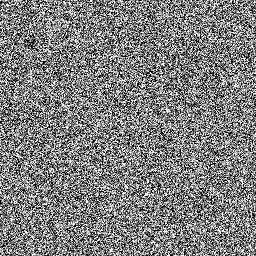

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=0.pt


 11%|█         | 11/100 [21:44<2:41:59, 109.20s/it]

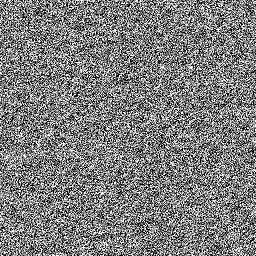

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=10.pt


 21%|██        | 21/100 [41:42<2:23:41, 109.13s/it]

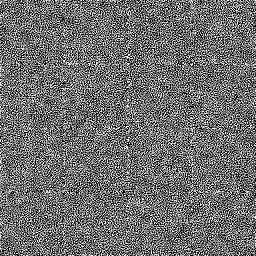

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=20.pt


 31%|███       | 31/100 [1:01:34<2:05:22, 109.02s/it]

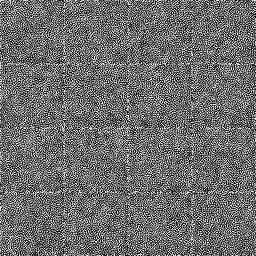

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=30.pt


 41%|████      | 41/100 [1:21:35<1:48:28, 110.32s/it]

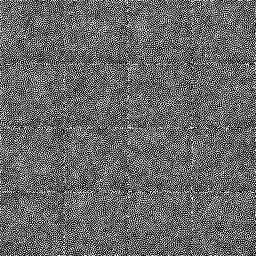

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=40.pt


 51%|█████     | 51/100 [1:41:44<1:29:56, 110.12s/it]

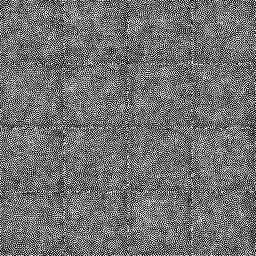

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=50.pt


 61%|██████    | 61/100 [2:01:38<1:11:01, 109.27s/it]

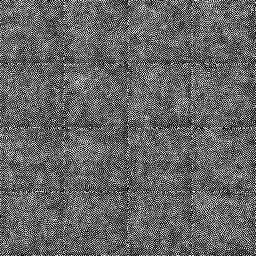

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=60.pt


 71%|███████   | 71/100 [2:21:39<53:01, 109.71s/it]

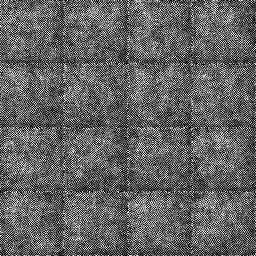

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=70.pt


 81%|████████  | 81/100 [2:41:40<34:44, 109.69s/it]

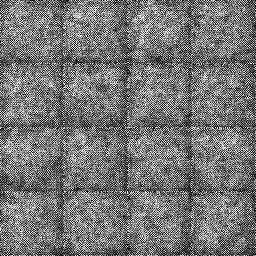

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=80.pt


 91%|█████████ | 91/100 [3:01:39<16:26, 109.65s/it]

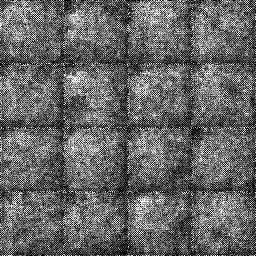

checkpoint saved to data/interim/imagen-pytorch/fold=0/checkpoint/epoch=90.pt


100%|██████████| 100/100 [3:19:51<00:00, 119.92s/it]

CPU times: user 3h 18min 28s, sys: 1min 12s, total: 3h 19min 40s
Wall time: 3h 19min 51s


In [ ]:
%%time
# capture the tqdm output (which keeps printing newlines) to avoid Colab crash
from IPython.utils import io
# train each unet in concert, or separately (recommended) to completion
l_arr = [[],[]]

with tqdm(total=epochs) as pbar:
  for epoch in range(epochs):
    for u in (1, 2):
      with io.capture_output() as captured:
        loss = trainer(training_images, unet_number=u, max_batch_size=max_batch_size)
        trainer.update(unet_number=u)
      l_arr[u-1].append(loss)
    pbar.update()
    if epoch % checkpoint_rate == 0 or epoch == len(epochs) - 1:
      with io.capture_output() as captured:
        images = trainer.sample(batch_size=16, return_pil_images=True)
      display(image_grid(images, 4, 4))
      if not math.isnan(loss):
        trainer.save(path.join(checkpoint_folder, f"epoch={epoch}.pt"))

## Sampling

In [ ]:
with io.capture_output() as captured:
  images = trainer.sample(batch_size=16, return_pil_images=True)
  trainer.save(path.join(results_folder, f"epochs={epoch}.pt"))

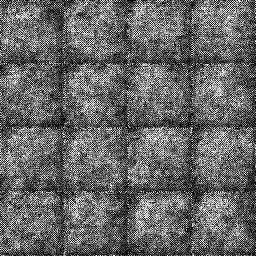

In [ ]:
display(image_grid(images, 4, 4))

## deallocate CUDA memory
https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28

In [ ]:
!nvidia-smi

Thu Oct  6 01:20:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    51W / 400W |  23670MiB / 40536MiB |      1%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import runtime
runtime.unassign()